# Yelp: Business Analysis

In [1]:
!spark-shell --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.1.1
      /_/
                        
Using Scala version 2.12.13, OpenJDK 64-Bit Server VM, 1.8.0_292
Branch HEAD
Compiled by user  on 2021-06-23T22:10:53Z
Revision e9c1449899ac58a10ea28ca6f1e8ed6c7c254d54
Url https://bigdataoss-internal.googlesource.com/third_party/apache/spark
Type --help for more information.


<details>
<summary><b>Table of Contents</b> (click to open)</summary>
<!-- MarkdownTOC -->

1. [Top Businesses](#topbs)
1. [Impact of reviews on Businesses ](#revimpact)
1. [Top Restaurants](#toprest)
1. [Categories by Businesses](#catbs)
1. [Vegetarian Restuarants](#vegres)
1. [Top Category/Cuisine](#cuisine)
<!-- /MarkdownTOC -->
</details>

### Import Libraries

In [2]:
import seaborn as sns
import folium
import numpy as np
import matplotlib.pyplot as plt

import pyspark.sql.functions as F
from pyspark.sql.functions import col

In [3]:
font_size = 16
params = {"axes.titlesize": font_size,
          "axes.labelsize": font_size*.7,
          "xtick.labelsize": font_size*.5,
          "ytick.labelsize": font_size*.5,
          "legend.fontsize": font_size*.5,
          "figure.figsize": (20, 10),
          "axes.titlepad": 25}

plt.style.use('seaborn-darkgrid')
sns.set_context("notebook", rc=params)

## Load Data

Load the review data from google cloud storage to dataproc

In [4]:
file_review = "gs://proj-spark/yelp-dataset/yelp_academic_dataset_review.json"
file_business = "gs://proj-spark/yelp-dataset/yelp_academic_dataset_business.json"
file_users = "gs://proj-spark/yelp-dataset/yelp_academic_dataset_user.json"
file_checkin = "gs://proj-spark/yelp-dataset/yelp_academic_dataset_checkin.json"
file_tip = "gs://proj-spark/yelp-dataset/yelp_academic_dataset_tip.json"

In [5]:
df_review = spark.read.format('json').load(file_review)
df_review.createOrReplaceTempView('reviewTable')

df_business = spark.read.format('json').load(file_business)
df_business.createOrReplaceTempView('businessTable')

df_users = spark.read.format('json').load(file_users)
df_users.createOrReplaceTempView('usersTable')

df_checkin = spark.read.format('json').load(file_checkin)
df_checkin.createOrReplaceTempView('checkinTable')

df_tip = spark.read.format('json').load(file_tip)
df_tip.createOrReplaceTempView('tipTable')

## Top Businesses <a class="anchor" id="topbs"></a>

In [6]:
# checkin count for each business
df_checkin_cnt = df_checkin.withColumn('checkin_count', F.size(F.split(col('date'),', ')))

# join the checkin info with businesses data
joinExpression = df_business['business_id'] == df_checkin_cnt['business_id']
df_bs_checkin = df_business.join(df_checkin_cnt, joinExpression)\
                           .drop(df_checkin_cnt['business_id'])

In [7]:
top = 5
df_top_bs = df_bs_checkin.orderBy(F.desc('checkin_count')).limit(top)

In [8]:
# top 5 businesses on yelp
df_top_bs.select('business_id', 'name', 'city', 'state', 'stars', 'checkin_count', 'review_count').toPandas()

,business_id,name,city,state,stars,checkin_count,review_count
0,7sxYa0-TwWeWGFr5CvMMkw,Hartsfield-Jackson Atlanta International Airpo...,Atlanta,GA,3.5,150005,3948
1,EqUqaLJxMDxIqvnmaKB4Lw,Portland International Airport - PDX,Portland,OR,4.5,75511,2136
2,2PxZ-fICnd432NJHefXrcA,Orlando International Airport - MCO,Orlando,FL,3.0,63982,2630
3,UlndVD4tezU3FACjZ2Qk2w,Austin-Bergstrom International Airport - AUS,Austin,TX,4.0,54657,1458
4,vITc1UkWLvG9pVdaOxyCnA,Boston Logan International Airport - BOS,Boston,MA,3.0,54361,1576


## Impact of reviews on Businesses  <a class="anchor" id="revimpact"></a>

Impact of reviews count on Business checkin in Oregon (State)

Text(0.5, 1.0, 'Impact of reviews on Business in Oregon')

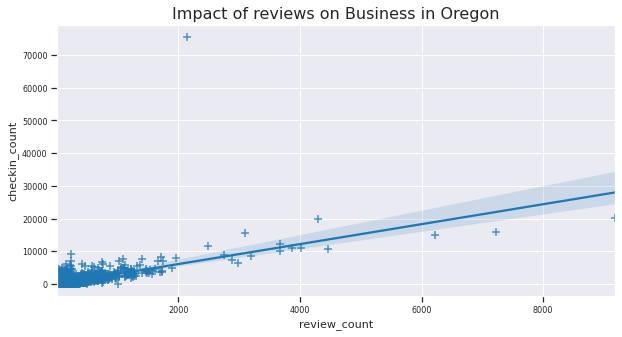

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
data = df_bs_checkin.filter("state = 'OR'").toPandas()
ax = sns.regplot(x='review_count', y='checkin_count', data=data, ax=ax,
                 marker="+", 
                 scatter_kws={"s": 50})
ax.set_title('Impact of reviews on Business in Oregon')

We can observed that business having high review count more likely to have high checkin count.

## Top Restaurants <a class="anchor" id="toprest"></a>

Based on number of checkin find the top restaurants business in Oregon

In [10]:
top = 10
df_top_res = df_bs_checkin.filter(col('categories').contains('Res'))\
    .filter("state = 'OR'")\
    .orderBy(F.desc('checkin_count'))\
    .limit(top)

Text(0.5, 1.0, 'Top Restaurants in Oregon')

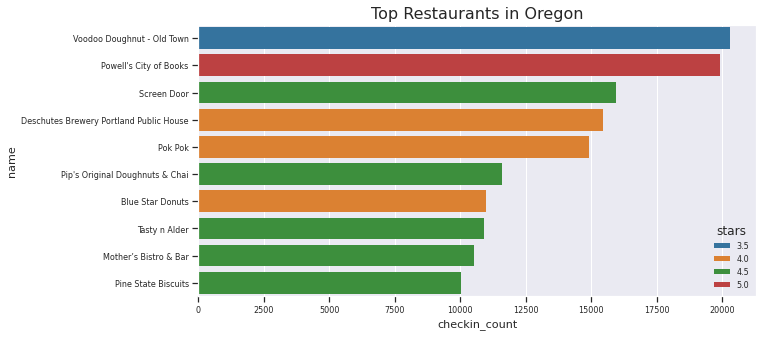

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
data = df_top_res.toPandas()
ax = sns.barplot(x='checkin_count', y='name', hue='stars', data=data, ax=ax, 
                 dodge=False, 
                 saturation=.7)
ax.set_title('Top Restaurants in Oregon')

## Categories by Businesses <a class="anchor" id="catbs"></a>

Total number of businesses per category

In [12]:
# Split the categories 
df_business = df_business.withColumn('categories_splitted', F.split(col('categories'),', '))\
    .withColumn('category', F.explode('categories_splitted'))

cat_grp = df_business.groupBy('category')\
    .agg(F.count('business_id').alias('business_count'))\
    .orderBy(F.desc('business_count'))

In [13]:
#cat_grp.count()
cat_grp.show()

+--------------------+--------------+
|            category|business_count|
+--------------------+--------------+
|         Restaurants|         50763|
|                Food|         29469|
|            Shopping|         26205|
|       Beauty & Spas|         16574|
|       Home Services|         16465|
|    Health & Medical|         15102|
|      Local Services|         12192|
|           Nightlife|         11990|
|                Bars|         10741|
|          Automotive|         10119|
|Event Planning & ...|          9644|
|         Active Life|          9231|
|        Coffee & Tea|          7725|
|          Sandwiches|          7272|
|             Fashion|          6599|
|American (Traditi...|          6541|
|         Hair Salons|          5900|
|               Pizza|          5756|
|     Hotels & Travel|          5703|
|  Breakfast & Brunch|          5505|
+--------------------+--------------+
only showing top 20 rows



Plot bar chart for top 15 categories

Text(0.5, 1.0, 'Categories by Businesses')

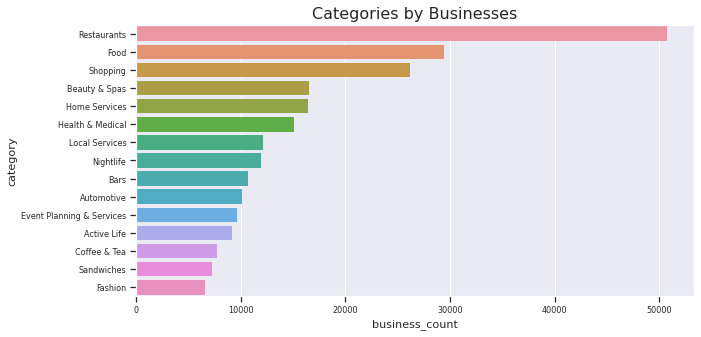

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x='business_count', y='category', data=cat_grp.limit(15).toPandas(), ax=ax)
ax.set_title('Categories by Businesses') 

## Vegetarian Restuarants <a class="anchor" id="vegres"></a>

Yelp Business dataset is the collection of different business in different areas. Restaurants is most popular among them. Let's analyze the Vegetarian Restuarants.

In [15]:
# Filter Vegetarian Restaurants
df_veg_restuarant = df_business.withColumn('categories_splitted', F.split(col('categories'),', '))\
    .filter(F.array_contains(col('categories_splitted'), 'Restaurants'))\
    .filter(F.array_contains(col('categories_splitted'), 'Vegetarian'))

In [16]:
# Number of Vegetarian restaurants in each city
df_rest_city = df_veg_restuarant.groupBy('city').count().orderBy(F.desc('count'))

Top-10 Cities for Vegetarian Restaurants

Text(0.5, 1.0, 'Top Cities for Vegetarian Restaurants')

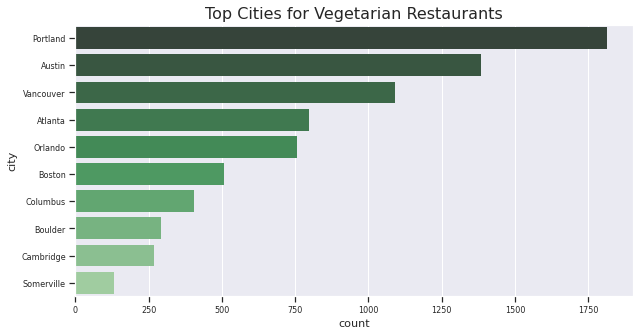

In [17]:
# Plot top-10 Cities for Vegetarian Restaurants
top = 10
data = df_rest_city.limit(top).toPandas()
fig, ax = plt.subplots(figsize=(10,5))
palette = np.array(sns.color_palette('Greens_d', top))[::-1]
ax = sns.barplot(x='count', y='city', data=data, palette=palette)
ax.set_title('Top Cities for Vegetarian Restaurants')

Top Vegetarian Restaurants in Portland city which are open

In [18]:
df_portland = df_veg_restuarant.filter("city='Portland'")\
    .filter("is_open=1")\
    .withColumn('OutdoorSeating', col('attributes.OutdoorSeating'))\
    .orderBy(F.desc('stars'))

Text(0.5, 0.98, 'Top Vegetarian Restaurants in Portland')

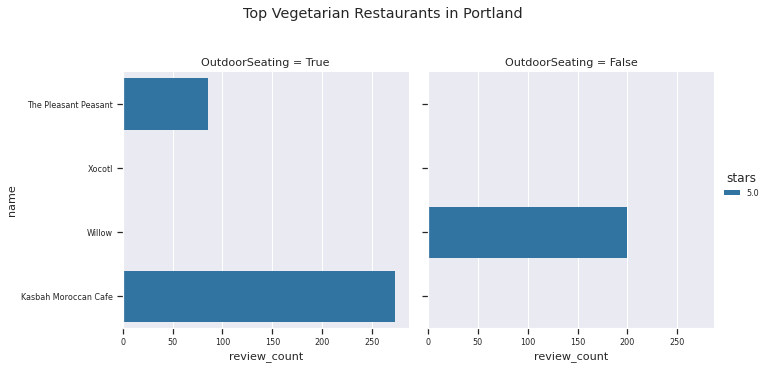

In [22]:
# Plot top-10 Vegetarian Restaurants in Portland
top = 20
data = df_portland.limit(top).toPandas()
facetgrid = sns.catplot(x='review_count', y='name', 
                        hue='stars', 
                        col='OutdoorSeating', 
                        kind='bar', 
                        data=data)
facetgrid.fig.subplots_adjust(top=0.8) 
facetgrid.fig.suptitle('Top Vegetarian Restaurants in Portland')

In [23]:
#Geographical Map of Vegetarian restuarant in Portland

portland_map = folium.Map(location=[45.5051,-122.6750], tiles='OpenStreetMap', zoom_start=11)

for idx, row in data.iterrows():
    text = f"""
        <header>
            <h6><b>Name: {row['name']}</b></h6>
        </header>
        <hr style='margin:10px;'>
        <ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px'>
            <li> Stars: {row['stars']} </li>
            <li> Review Count: {row['review_count']} </li>
            <li> OutdoorSeating: {row['OutdoorSeating']} </li>
        </ul>
    """
    popup = folium.Popup(folium.Html(text,script=True), max_width=2650)
    folium.Marker([row['latitude'], row['longitude'] ], popup=popup, tooltip="Click!")\
        .add_to(portland_map)

In [24]:
portland_map

## Top Category/Cuisine <a class="anchor" id="cuisine"></a>

In [25]:
def filter_business(city, category):
    """Filter business based on city and category"""
    def _(df):
        return df.filter(col('city')==city)\
            .withColumn('categories_splitted', F.split(col('categories'),', '))\
            .filter(F.array_contains(col('categories_splitted'), category))\
            .withColumn('category', F.explode('categories_splitted'))
    return _

def ntop_category(n:int=10):
    """Top n category"""
    return lambda df: (
        df.groupBy('category')\
            .count()\
            .orderBy(F.desc('count'))\
            .limit(n)
    )

In [26]:
def ntop_cuisine(n, city):
    """ """
    def _(df):
        return df.transform(filter_business(city, 'Restaurants'))\
            .transform(ntop_category())\
            .filter("category != 'Restaurants'")\
            .filter("category != 'Food'")
    return _

In [27]:
# Top Category/Cuisine in Portland, Austin, Atlanta, Boston
top = 10
cities = ['Portland', 'Austin', 'Atlanta', 'Boston']

data = {}
for city in cities:
    data[city] = df_business.transform(ntop_cuisine(top, city)).toPandas()

Text(0.5, 1.0, 'Top categories for Boston Restaurants')

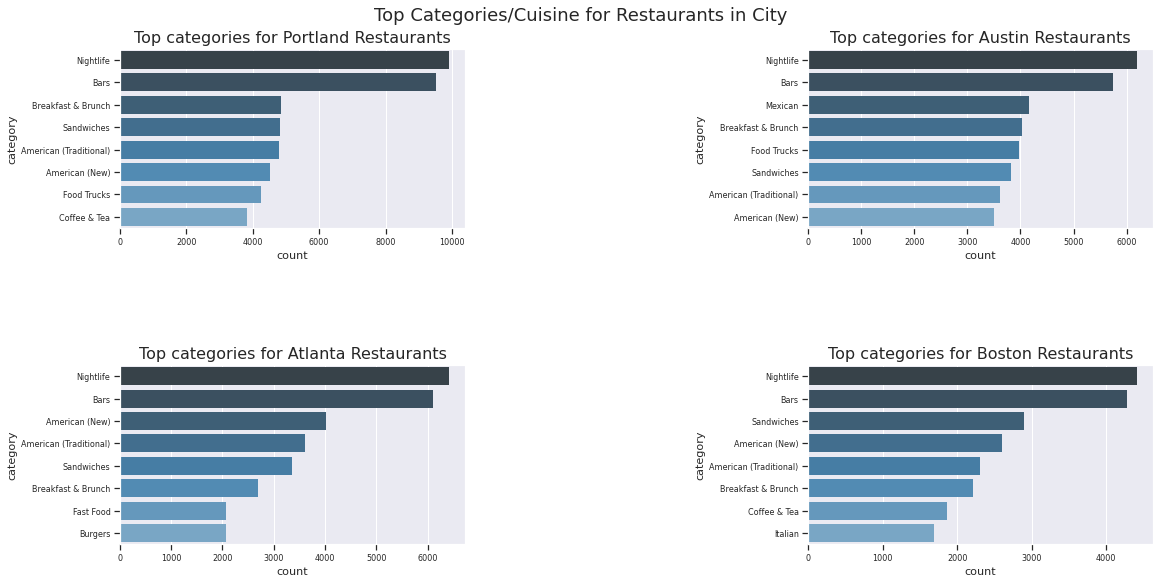

In [28]:
# figure and grid for ploting
fig = plt.figure(figsize=(16, 8), constrained_layout=True)
grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3, figure=fig)
fig.suptitle('Top Categories/Cuisine for Restaurants in City', fontsize=18)
palette = np.array(sns.color_palette("Blues_d", top))[::-1]

# Top categories for Portland Restaurants
portland_cat = data['Portland']
ax = plt.subplot(grid[0, 0])
ax = sns.barplot(x='count', y='category', data=portland_cat, ax=ax, palette=palette)
ax.set_title('Top categories for Portland Restaurants')

# Top categories for Austin Restaurants
austin_cat = data['Austin']
ax = plt.subplot(grid[0, 1])
ax = sns.barplot(x='count', y='category', data=austin_cat, ax=ax, palette=palette)
ax.set_title('Top categories for Austin Restaurants')

# Top categories for Austin Restaurants
alanta_cat = data['Atlanta']
ax = plt.subplot(grid[1, 0])
ax = sns.barplot(x='count', y='category', data=alanta_cat, ax=ax, palette=palette)
ax.set_title('Top categories for Atlanta Restaurants')

# Top categories for Boston Restaurants
boston_cat = data['Boston']
ax = plt.subplot(grid[1, 1])
ax = sns.barplot(x='count', y='category', data=boston_cat, ax=ax, palette=palette)
ax.set_title('Top categories for Boston Restaurants')